<a href="https://colab.research.google.com/github/Apyarn95/timeSeriesForecasting/blob/main/VARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm 

from datetime import datetime 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX 
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score 
from sklearn.preprocessing import StandardScaler

In [ ]:
# Importing from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! wget https://lazyprogrammer.me/course_files/timeseries/temperature.csv

--2023-03-06 09:28:28--  https://lazyprogrammer.me/course_files/timeseries/temperature.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075992 (3.9M) [text/csv]
Saving to: ‘temperature.csv’

temperature.csv     100%[===================>]   3.89M  2.32MB/s    in 1.7s    

2023-03-06 09:28:30 (2.32 MB/s) - ‘temperature.csv’ saved [4075992/4075992]



In [ ]:
#loading dataset from drive
df = pd.read_csv('temperature.csv')


In [ ]:
def parse_date(row):
  s = f"{row['year']}-{row['month']}-{row['day']}"
  return datetime.strptime(s, "%Y-%m-%d")

In [ ]:
# The dimensions of the model would be T X D where T = no. of time series and D = number of cities ( here we would consider 2 cities)

df['Date'] = df.apply(parse_date, axis=1)

In [ ]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-01-01
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-02-01
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-03-01
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-04-01
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-05-01


In [ ]:
auckland  = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [ ]:
# Keep only columns we want 
auckland  = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date','AverageTemperatureFahr']].copy()

In [ ]:
print(auckland.head())
print(stockholm.head())


        Date  AverageTemperatureFahr
5 1853-06-01                 51.9062
6 1853-07-01                 52.3886
7 1853-08-01                 52.8530
8 1853-09-01                 52.5776
9 1853-10-01                 54.8726
            Date  AverageTemperatureFahr
31416 1743-11-01                 42.8414
31421 1744-04-01                 36.8888
31422 1744-05-01                 45.1220
31423 1744-06-01                 53.1824
31424 1744-07-01                 60.0260


In [ ]:
# Set index to date column , we don't want the date to be a column but an index 
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']
print(auckland.head())

            AucklandTemp
Date                    
1853-06-01       51.9062
1853-07-01       52.3886
1853-08-01       52.8530
1853-09-01       52.5776
1853-10-01       54.8726


In [ ]:
# Set index to date column , we don't want the date to be a column but an index 
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']
# print(auckland.head())

In [ ]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [ ]:
joined = auckland.join(stockholm, how='outer') #has some missing data

In [ ]:
joined.shape

(3155, 2)

In [ ]:
# select last 500 rows 
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [ ]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

<AxesSubplot:xlabel='Date'>

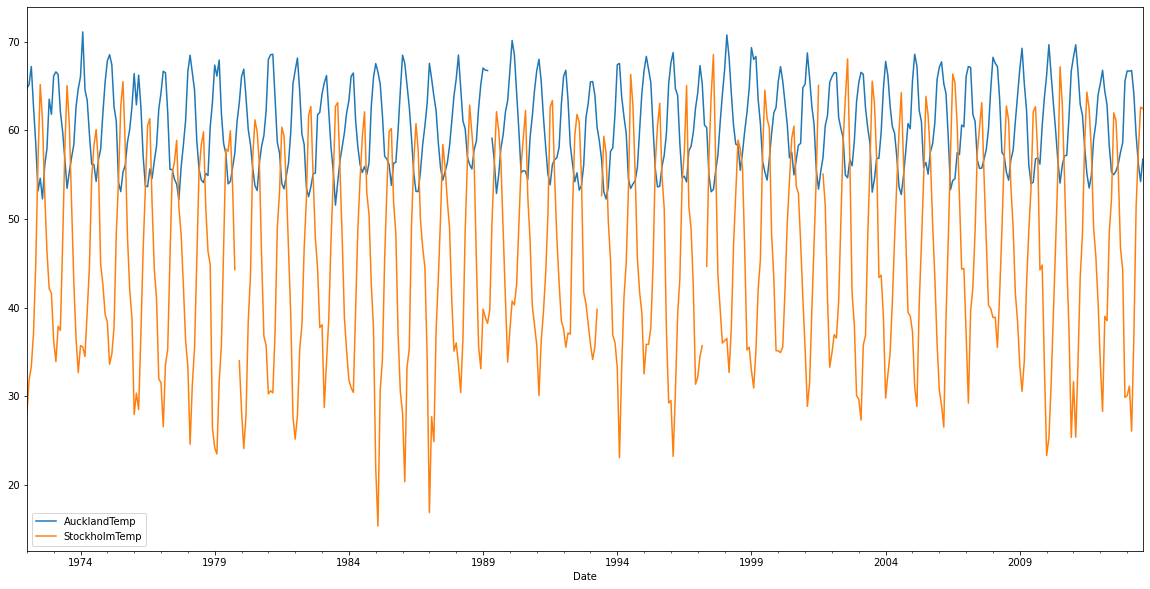

In [ ]:
joined_part.plot(figsize=(20,10))

In [ ]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [ ]:
print(type(train[['AucklandTemp']]))
print(type(train['AucklandTemp']))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
train.head()

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140
1972-04-01,62.6378,37.1462
1972-05-01,58.4708,44.9906


In [ ]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(
      train[['AucklandTemp']])

test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])
print(train.head())

            AucklandTemp  StockholmTemp  ScaledAuckland
Date                                                   
1972-01-01       64.7312        27.9194        0.912925
1972-02-01       65.2010        31.8020        1.010821
1972-03-01       67.2116        33.3140        1.429784
1972-04-01       62.6378        37.1462        0.476709
1972-05-01       58.4708        44.9906       -0.391598


In [ ]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_auckland.fit_transform(
      train[['StockholmTemp']])

test['ScaledStockholm'] = scaler_auckland.transform(test[['StockholmTemp']])
print(train.head())

            AucklandTemp  StockholmTemp  ScaledAuckland  ScaledStockholm
Date                                                                    
1972-01-01       64.7312        27.9194        0.912925        -1.487785
1972-02-01       65.2010        31.8020        1.010821        -1.147552
1972-03-01       67.2116        33.3140        1.429784        -1.015055
1972-04-01       62.6378        37.1462        0.476709        -0.679239
1972-05-01       58.4708        44.9906       -0.391598         0.008166


In [ ]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [ ]:
train.index[-1]

Timestamp('2012-08-01 00:00:00', freq='MS')

In [ ]:
test.head()

,AucklandTemp,StockholmTemp,ScaledAuckland,ScaledStockholm
Date,,,,
2012-09-01,56.1812,55.5710,-0.868698,0.935328
2012-10-01,57.5078,46.7798,-0.592265,0.164954
2012-11-01,58.6076,44.2382,-0.363092,-0.057767
2012-12-01,65.5538,29.8526,1.084336,-1.318378
2013-01-01,66.7220,30.0578,1.327762,-1.300397


In [ ]:
# putting back in original dataset
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

<AxesSubplot:xlabel='Date'>

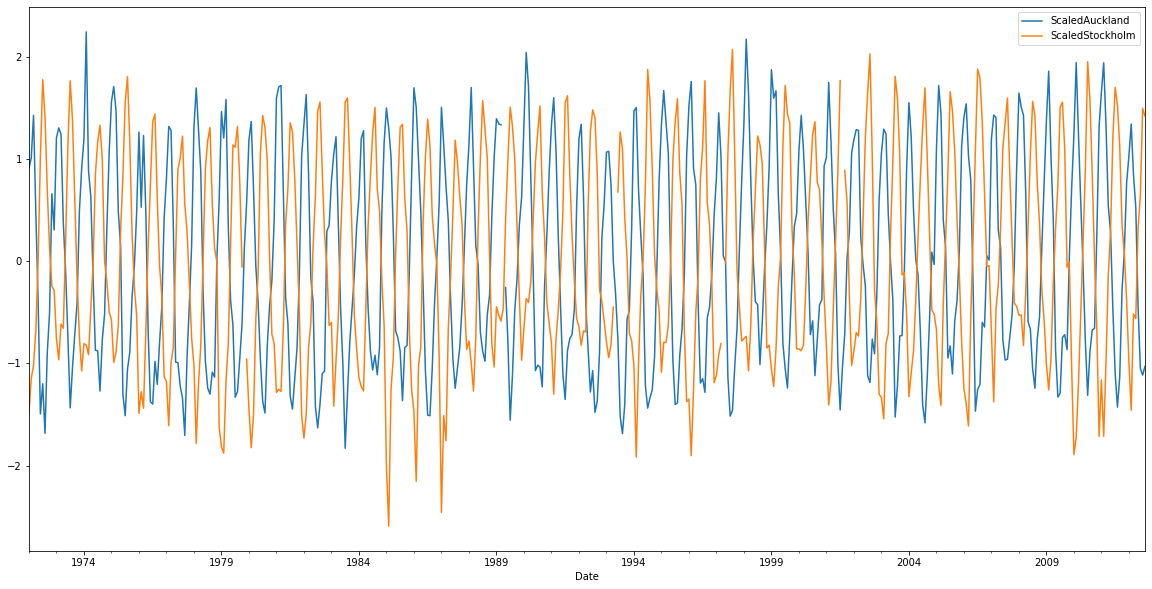

In [ ]:
cols = ['ScaledAuckland' , 'ScaledStockholm']
train[cols].plot(figsize=(20,10))

In [ ]:
to = datetime.now()
model = VARMAX(train[cols], order=(10,10)) #p=10,q=10
res = model.fit(maxiter=100)
print("Duration: ", datetime.now() - to)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration:  0:05:53.406627


In [ ]:
fcast = res.get_forecast(Ntest)

In [ ]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01    0.000188
1972-02-01    0.821573
1972-03-01    0.710076
1972-04-01    0.818552
1972-05-01   -0.091824
                ...   
2012-04-01    0.552079
2012-05-01   -0.287870
2012-06-01   -1.056615
2012-07-01   -1.326272
2012-08-01   -1.078349
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [ ]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

In [ ]:
joined_part.head()

,AucklandTemp,StockholmTemp,ScaledAuckland,ScaledStockholm,Train Pred Auckland,Test Pred Auckland
Date,,,,,,
1972-01-01,64.7312,27.9194,0.912925,-1.487785,0.000188,NaN
1972-02-01,65.2010,31.8020,1.010821,-1.147552,0.821573,NaN
1972-03-01,67.2116,33.3140,1.429784,-1.015055,0.710076,NaN
1972-04-01,62.6378,37.1462,0.476709,-0.679239,0.818552,NaN
1972-05-01,58.4708,44.9906,-0.391598,0.008166,-0.091824,NaN


<AxesSubplot:xlabel='Date'>

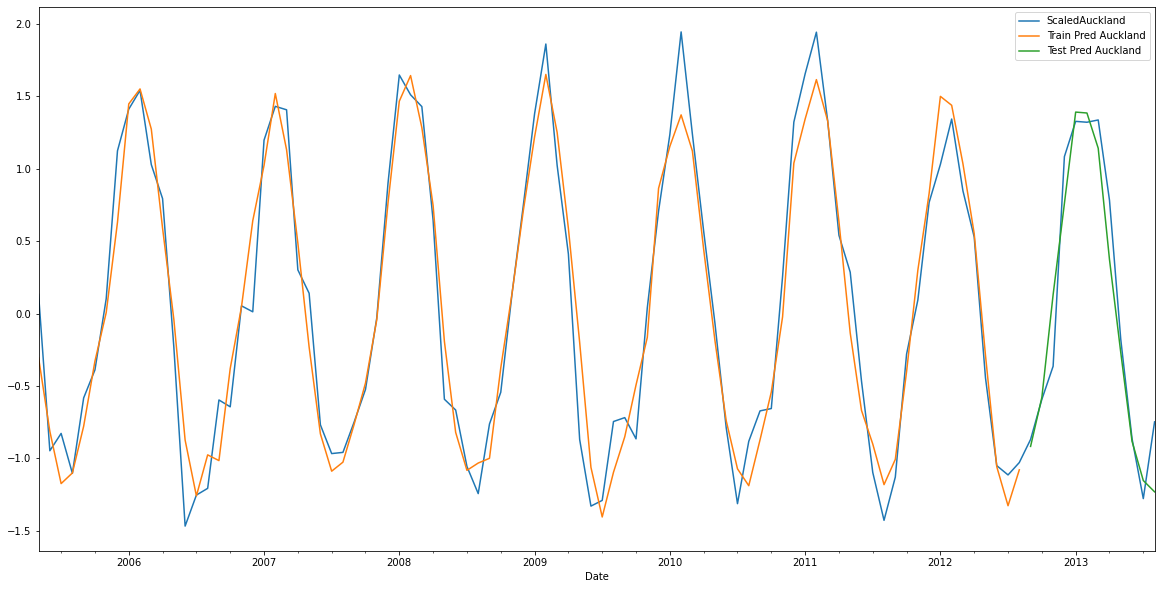

In [ ]:
plot_cols = ['ScaledAuckland' , 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(20,10))

In [ ]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

<AxesSubplot:xlabel='Date'>

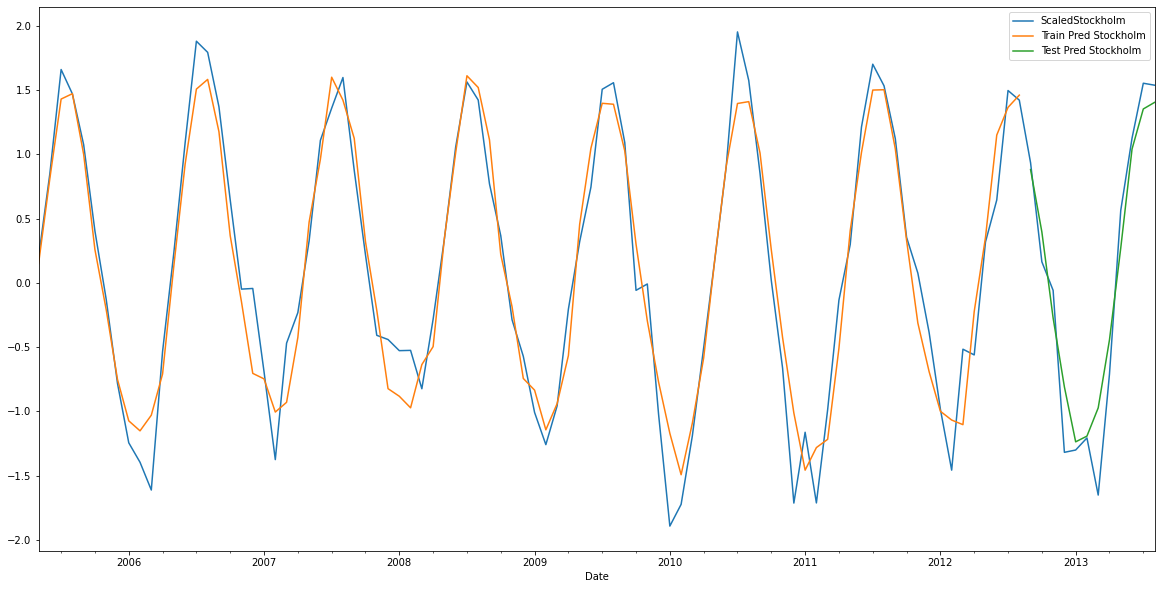

In [ ]:
plot_cols = ['ScaledStockholm' , 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(20,10))

## VAR

Now we would implement a VAR model 

In [ ]:
# train.drop(['testColumn'], axis=1)
train_mod = train.dropna()
print(len(train_mod))

483


In [ ]:
model = VAR(train_mod[cols])

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
lag_order_results = model.select_order(maxlags = 15)
lag_order_results

In [ ]:
lag_order_results.selected_orders

{'aic': 11, 'bic': 6, 'hqic': 11, 'fpe': 11}

In [ ]:
results = model.fit(maxlags=15, ic='aic')

In [ ]:
# fetch the lag order generated from the results 
lag_order = results.k_ar

In [ ]:
# unlike other models where we train first and then forecast on the given time steps
# in VAR we pass the prior time series steps and then anticipate the results
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest) # in the forecast function we pass the prior frame and predict the future value
# returns a numpy array instead of an object 

In [ ]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast[:,0]

IndexError: ignored

<AxesSubplot:xlabel='Date'>

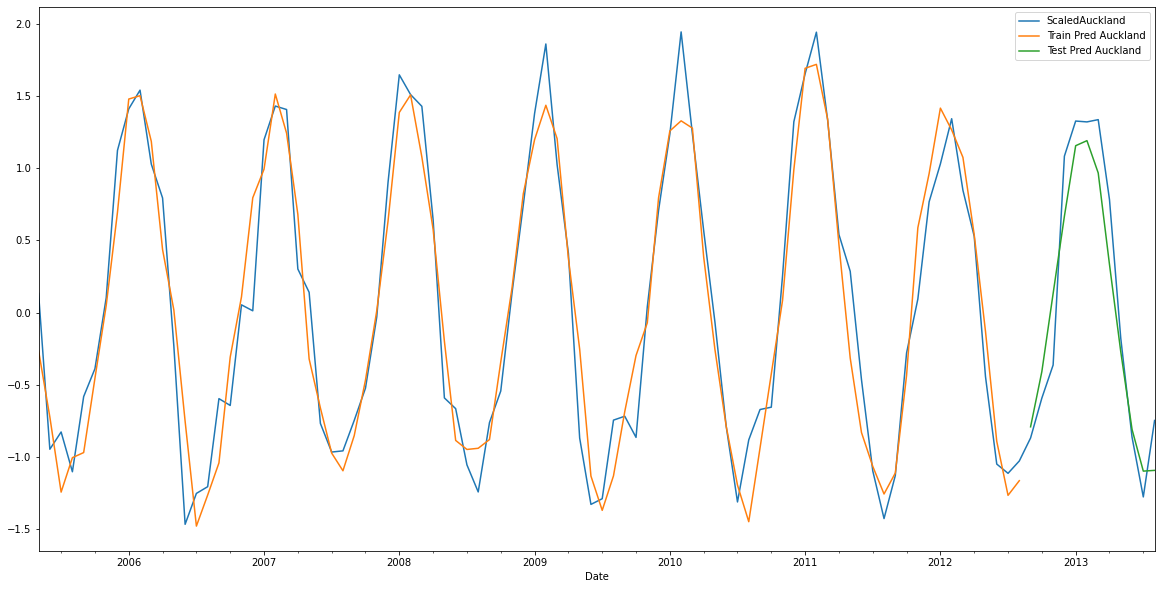

In [ ]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(20,10))

In [ ]:
# calculate the r^2 error 

joined_part = joined_part.dropna()
print(len(joined_part))
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']

y_true = y_true.iloc[lag_order: ]
y_pred = y_pred.iloc[lag_order: ]


for i in range(len(y_true)):
  print(i,y_true[i])

# print("Auckland Train R^2", r2_score(y_true, y_pred))



0


IndexError: ignored